# FCNN training

In [21]:
# This is only valid when the package is not installed
import sys
sys.path.append('../../') # two folders up
import DeepINN as dp
import torch

## Geometry

In [22]:
# A simple 1D geometry
X = dp.spaces.R1('x')
Line = dp.domains.Interval(X, 0, 1)

In [23]:
left_bc = dp.constraint.DirichletBC(geom = Line,
                                      function = lambda X: torch.tensor([0.0]),
                                      sampling_strategy = "grid",
                                      no_points = 1, # you can use more points. there are conditions to deal with stupid conditions. 
                                      filter_fn = lambda x: x[:] == 0.0)
right_bc = dp.constraint.DirichletBC(geom = Line,
                                      function = lambda X: torch.tensor([1.0]),
                                      sampling_strategy = "grid",
                                      no_points = 1, # you can use more points. there are conditions to deal with stupid conditions. 
                                      filter_fn = lambda x: x[:] == 1.0)
interior_points = dp.constraint.PDE(geom = Line,
                                    sampling_strategy= "grid",
                                    no_points = 20)

In [24]:
# dp.utils.scatter(X, interior_points.sampler_object(), dpi = 50)
# dp.utils.scatter(X, left_bc.sampler_object(), dpi = 50)
# dp.utils.scatter(X, right_bc.sampler_object(), dpi = 50)

## PDE

In [25]:
def laplace(X,y):
    """
    1D Laplace equation.
    u__x = 0 
    """
    dy_x = dp.constraint.Jacobian(X, y)
    dy_xx = dp.constraint.Jacobian(X, y)(i = 0, j = 0)

    return dy_xx

In [26]:
domain = dp.domain.Generic(laplace,
                            interior_points,
                            [left_bc, right_bc])

## Network

In [27]:
activation = "tanh"
initialiser = "Xavier normal"
layer_size = [1] + [5] * 1 + [1]

In [28]:
net = dp.nn.FullyConnected(layer_size, activation, initialiser)
model = dp.Model(domain, net)

In [29]:
optimiser = "adam"
lr=0.001
metrics="MSE"

model.compile(optimiser, lr, metrics, device = "cuda")

/home/hell/Desktop/repos/DeepINN/Tutorials/5. FCNN/../../DeepINN/geometry/samplers/grid_samplers.py:78: UserWarning: First iteration did not find any valid grid points, for
                             the given filter.
                             Will try again with n = 10 * self.n_points. Or
                             else use only random points!
  warnings.warn("""First iteration did not find any valid grid points, for
Domain compiled
Network compiled


In [30]:
model.optimiser_function, model.lr, model.metric

(torch.optim.adam.Adam, 0.001, MSELoss())

In [31]:
model.train(iterations = 5000)

Iteration: 1 	 BC Loss: 0.2236	 PDE Loss: 1.2173 	 Loss: 1.4410
Iteration: 501 	 BC Loss: 0.2387	 PDE Loss: 0.0058 	 Loss: 0.2445
Iteration: 1001 	 BC Loss: 0.2386	 PDE Loss: 0.0054 	 Loss: 0.2440
Iteration: 1501 	 BC Loss: 0.2385	 PDE Loss: 0.0055 	 Loss: 0.2440
Iteration: 2001 	 BC Loss: 0.2385	 PDE Loss: 0.0055 	 Loss: 0.2440
Iteration: 2501 	 BC Loss: 0.2385	 PDE Loss: 0.0055 	 Loss: 0.2440
Iteration: 3001 	 BC Loss: 0.2384	 PDE Loss: 0.0055 	 Loss: 0.2439
Iteration: 3501 	 BC Loss: 0.2384	 PDE Loss: 0.0055 	 Loss: 0.2439
Iteration: 4001 	 BC Loss: 0.2383	 PDE Loss: 0.0055 	 Loss: 0.2439
Iteration: 4501 	 BC Loss: 0.2383	 PDE Loss: 0.0056 	 Loss: 0.2438
Iteration: 5001 	 BC Loss: 0.2382	 PDE Loss: 0.0056 	 Loss: 0.2438
Training finished


In [32]:
# model.iter = 1
# model.train(iterations = 2000)

In [33]:
import matplotlib.pyplot as plt

In [34]:
model.collocation_point_sample

tensor([[0.0476],
        [0.0952],
        [0.1429],
        [0.1905],
        [0.2381],
        [0.2857],
        [0.3333],
        [0.3810],
        [0.4286],
        [0.4762],
        [0.5238],
        [0.5714],
        [0.6190],
        [0.6667],
        [0.7143],
        [0.7619],
        [0.8095],
        [0.8571],
        [0.9048],
        [0.9524]], device='cuda:0', requires_grad=True)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

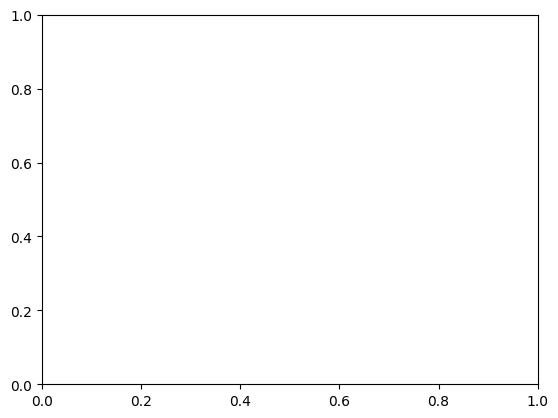

In [35]:
plt.scatter(model.collocation_point_sample, model.BC_forward)